In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import root_scalar


In [22]:
# Paramètres du modèle de Black-Scholes
S0 = 100  
r = 0.05 
sigma = 0.2  
T = 1 
n_simulations = 1000 
n_steps = 252  


In [23]:
# Définition des paramètres du modèle de Heston
S0 = 100  # Prix initial de l'actif sous-jacent
V0 = 0.04  # Volatilité initiale
r = 0.05  # Taux d'intérêt sans risque
kappa = 2  # Vitesse de réversion
theta = 0.04  # Niveau long terme de la volatilité
sigma = 0.3  # Volatilité de la volatilité
rho = -0.5  # Corrélation entre les mouvements browniens de l'actif et de la volatilité
T = 1  # Maturité des options
K = np.linspace(80, 720, 25)  # Différents prix d'exercice
N = 100#00 Nombre de simulations Monte Carlo
# Simulation des trajectoires de prix et de volatilité
M = 252  # Nombre de pas de temps dans une année
dt = T / M  # Pas de temps
n_simulations = 100  # Nombre de simulations
np.random.seed(42)

In [4]:
# Calcul des prix des options pour chaque prix d'exercice
option_prices = np.zeros_like(K)
for i, strike in enumerate(K):
    payoff_sum = 0
    for _ in range(N):
        # Simulation de la trajectoire du prix de l'actif sous-jacent et de la volatilité
        St = [S0]
        Vt = [V0]
        for t in range(1, M + 1):
            Z1 = np.random.normal(0, 1)
            Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * np.random.normal(0, 1)
            St.append(
                St[-1]
                * np.exp(
                    (r - 0.5 * Vt[-1]) * dt
                    + np.sqrt(Vt[-1] * dt) * Z1
                )
            )
            Vt.append(
                np.maximum(0, Vt[-1] + kappa * (theta - Vt[-1]) * dt + sigma * np.sqrt(Vt[-1] * dt) * Z2)
            )
        payoff_sum += np.maximum(St[-1] - strike, 0)
    option_prices[i] = payoff_sum / N


In [5]:
# Normalisation
option_prices_mean = np.mean(option_prices, axis=0)
option_prices_std = np.std(option_prices, axis=0)
#option_prices_norm = (option_prices - option_prices_mean) / option_prices_std

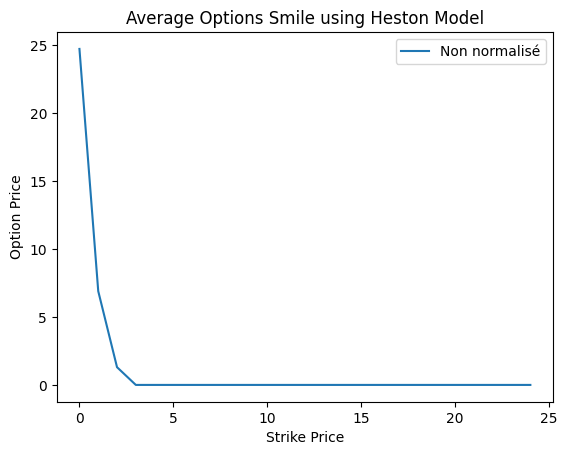

In [17]:
# Affichage du smile des options call
plt.plot(option_prices, label='Non normalisé')
#plt.plot(option_prices_norm, label='Normalisé')
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.title("Average Options Smile using Heston Model")
plt.legend()
plt.show()


In [35]:
np.random.seed(42)
def black_scholes_asset_prices(S0, r, sigma, T, n_simulations, n_steps):
    dt = T / n_steps
    asset_prices = np.zeros((n_simulations, n_steps + 1))
    asset_prices[:, 0] = S0
    for i in range(1, n_steps + 1):
        Z = np.random.normal(0, 1, n_simulations)
        asset_prices[:, i] = asset_prices[:, i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return asset_prices

In [39]:
asset_prices = black_scholes_asset_prices(S0, r, sigma, T, n_simulations, n_steps)

strikes = np.linspace(80, 720, 50)  # Différents prix d'exercice pour le call
option_prices = np.zeros_like(strikes)  # Tableau pour stocker les prix du call
option_payoff0 = np.zeros_like(strikes)  # Tableau pour stocker les prix du call

for i, strike in enumerate(strikes):
    payoff0 = np.maximum(asset_prices[:,-1] - strike, 0)  
    payoffs = np.maximum(asset_prices[:,-1] - strike, 0)  
    option_prices[i] = np.mean(payoffs)
    option_payoff0[i] = payoffs[0,] # pay-off de la premiere simulation

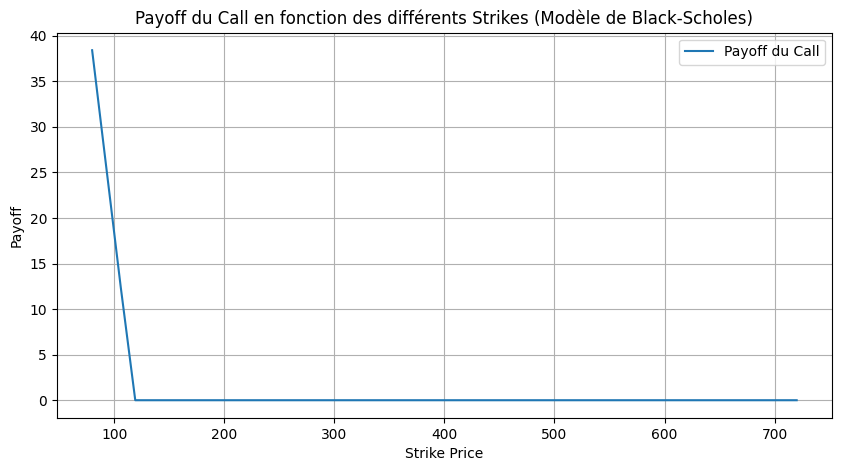

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(strikes, option_payoff0, label='Payoff du Call')
plt.xlabel('Strike Price')
plt.ylabel('Payoff')
plt.title('Payoff du Call en fonction des différents Strikes (Modèle de Black-Scholes)')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
def black_scholes_call(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

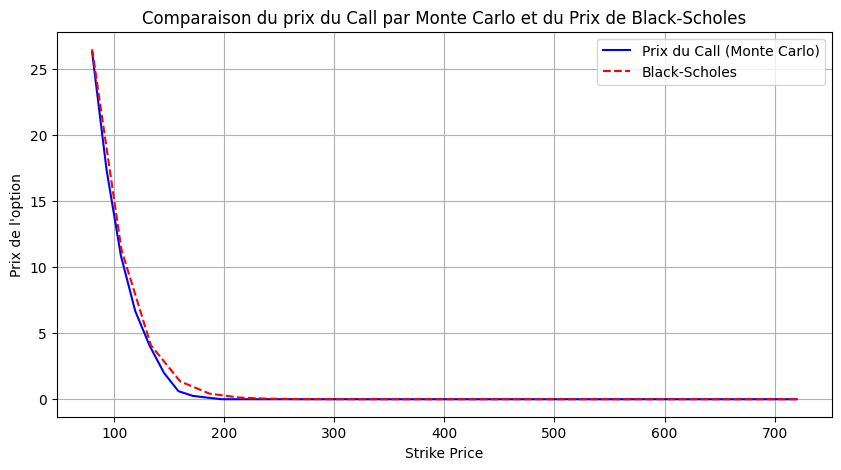

In [43]:
# Calcul du prix du call de Black-Scholes pour chaque prix d'exercice
black_scholes_prices = black_scholes_call(S0, K, r, T, sigma)


plt.figure(figsize=(10, 5))

plt.plot(strikes, option_prices, label='Prix du Call (Monte Carlo)', color='blue')


plt.plot(K, black_scholes_prices, label='Black-Scholes', linestyle='--', color='red')

plt.xlabel('Strike Price')
plt.ylabel('Prix de l\'option')
plt.title('Comparaison du prix du Call par Monte Carlo et du Prix de Black-Scholes')
plt.legend()
plt.grid(True)
plt.show()



In [44]:
def implied_volatility(T, K, r, C):
    epsilon = 1e-5  # Petit écart pour les approximations numériques
    delta_K = K * epsilon  # Petit incrément de K
    delta_T = T * epsilon  # Petit incrément de T
    
    # Approximations des dérivées partielles et seconde
    C_K = (black_scholes_call(S0, K + delta_K, r, T, sigma) - black_scholes_call(S0, K - delta_K, r, T, sigma)) / (2 * delta_K)
    C_T = (black_scholes_call(S0, K, r, T + delta_T, sigma) - black_scholes_call(S0, K, r, T - delta_T, sigma)) / (2 * delta_T)
    C_KK = (black_scholes_call(S0, K + delta_K, r, T, sigma) - 2 * black_scholes_call(S0, K, r, T, sigma) + black_scholes_call(S0, K - delta_K, r, T, sigma)) / (delta_K ** 2)
    
    # Calcul de la volatilité implicite
    imp_vol = np.sqrt(2 / T) * C / (K ** 2) * (1 - C_T / C_K + 0.5 * K * C_KK)
    
    return imp_vol


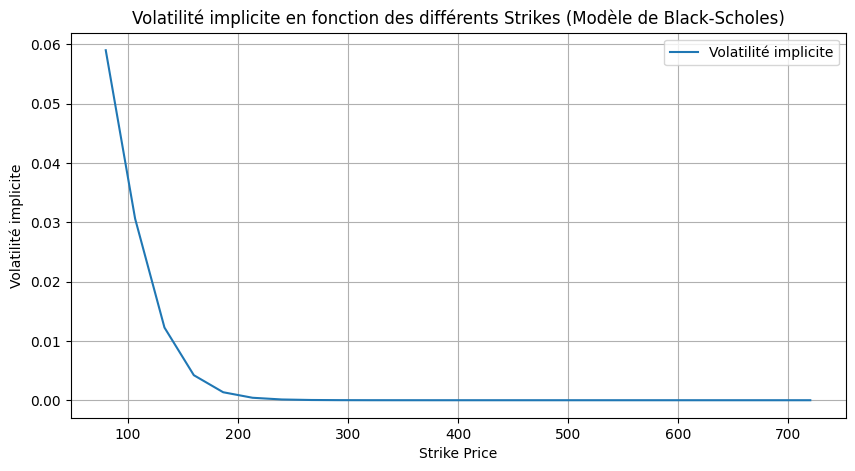

In [45]:

T = 1  
r = 0.05  

# Calcul de la volatilité implicite pour chaque prix d'exercice
implied_vols = np.zeros_like(K)  # Tableau pour stocker les volatilités implicites
for i, strike in enumerate(K):
    implied_vols[i] = implied_volatility(T, strike, r, black_scholes_prices[i])

# Affichage du graphe de la volatilité implicite en fonction des différents strikes
plt.figure(figsize=(10, 5))
plt.plot(K, implied_vols, label='Volatilité implicite')
plt.xlabel('Strike Price')
plt.ylabel('Volatilité implicite')
plt.title('Volatilité implicite en fonction des différents Strikes (Modèle de Black-Scholes)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def heston_option_prices(S0, V0, r, kappa, theta, sigma, rho, T, K, N, M):
    dt = T / M  # Pas de temps
    option_prices = np.zeros_like(K)  # Tableau pour stocker les prix des options

    for i, strike in enumerate(K):
        payoff_sum = 0
        for _ in range(N):
            # Simulation de la trajectoire du prix de l'actif sous-jacent et de la volatilité
            St = [S0]
            Vt = [V0]
            for t in range(1, M + 1):
                Z1 = np.random.normal(0, 1)
                Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * np.random.normal(0, 1)
                St.append(
                    St[-1]
                    * np.exp(
                        (r - 0.5 * Vt[-1]) * dt
                        + np.sqrt(Vt[-1] * dt) * Z1
                    )
                )
                Vt.append(
                    np.maximum(0, Vt[-1] + kappa * (theta - Vt[-1]) * dt + sigma * np.sqrt(Vt[-1] * dt) * Z2)
                )
            payoff_sum += np.maximum(St[-1] - strike, 0)
        option_prices[i] = payoff_sum / N

    return option_prices


In [48]:
# Calcul des volatilités implicites pour le modèle de Black-Scholes
implied_vols_black_scholes = np.zeros_like(K)
for i, strike in enumerate(K):
    implied_vols_black_scholes[i] = implied_volatility(S0, strike, r, T, black_scholes_prices[i])

# Calcul des volatilités implicites pour le modèle de Heston
implied_vols_heston = np.zeros_like(K)
for i, strike in enumerate(K):
    implied_vols_heston[i] = implied_volatility(S0, strike, r, T, option_prices[i])


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 16)

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(K, implied_vols_heston, label='Implied Volatility (Heston)')
plt.plot(K, implied_vols_black_scholes, label='Implied Volatility (Black-Scholes)')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Smile Comparison')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'implied_vols_heston' is not defined

<Figure size 1000x500 with 0 Axes>